In [17]:
import os
import numpy as np
import IPython
import copy
from shutil import copyfile

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.dont_write_bytecode=True

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from influence.inceptionModel2 import BinaryInceptionModel
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.experiments
from influence.dataset import DataSet
# from influence.dataset_poisoning import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.iter_attack import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.Progress import *

from load_animals import *

from skimage import io

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
img_side = 299
num_channels = 3
 
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]

weight_decay = 0.001

num_classes = 2
max_lbfgs_iter = 1000

# num_train_ex = 1800
# num_test_ex = 600
# batch_size = 100

# dataset_name = 'dogfish_%s_%s' % (num_train_ex, num_test_ex)
# # data_sets = load_animals(
# #     num_train_ex_per_class=num_train_ex_per_class, 
# #     num_test_ex_per_class=num_test_ex_per_class,
# #     classes=['dog', 'fish'])
# # data_sets = load_dogfish_with_orig_and_koda()
# # X, Y = load_koda()
# # print(X.shape, Y.shape)
# data_sets = new_load_dogfish_with_koda(num_train_ex, num_test_ex)

num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100

# dataset_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
dataset_name = ''
# extract_and_rename_animals()
data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    classes=['Eagle', 'Komodo_Dragon', 'Snail', 'Ox', 'Mushroom'])
#     classes=['dog', 'fish'])

np.random.seed()

full_graph = tf.Graph()
top_graph = tf.Graph()

def render_img(img):
    img_copy = np.copy(img)
    img_copy /= 2
    img_copy += 0.5
    io.imshow(img_copy)

../../5classes/Eagle
../../5classes/Komodo_Dragon
../../5classes/Snail
../../5classes/Ox
../../5classes/Mushroom
Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


KeyboardInterrupt: 

In [5]:
data_sets.train.x

array([[-0.9137255 , -0.9137255 , -0.9137255 , ..., -0.9137255 ,
        -0.8980392 , -0.90588236],
       [ 0.5921569 ,  0.6627451 ,  0.79607844, ..., -0.14509805,
         0.12156863, -0.6156863 ],
       [-0.60784316, -0.4509804 , -0.03529412, ..., -0.52156866,
        -0.46666667, -0.40392157],
       ...,
       [ 0.40392157,  0.69411767, -0.31764707, ..., -0.78039217,
        -0.6627451 , -0.96862745],
       [-0.8901961 , -0.8117647 , -0.81960785, ..., -0.7490196 ,
        -0.6392157 , -0.6156863 ],
       [-0.08235294, -0.10588235, -0.22352941, ..., -0.8509804 ,
        -0.73333335, -0.5529412 ]], dtype=float32)

In [12]:
print('*** Full:')
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)
    
    for data_set, label in [
        (data_sets.train, 'train'),
        (data_sets.test, 'test')]:

        inception_features_path = 'output/%s_inception_features_new_%s.npz' % (dataset_name, label)
        if not os.path.exists(inception_features_path):

            print('Inception features do not exist. Generating %s...' % label)
            data_set.reset_batch()
            
            num_examples = data_set.num_examples
#             assert num_examples % batch_size == 0

            inception_features_val = generate_inception_features(
                full_model, 
                data_set.x, 
                data_set.labels, 
                batch_size=batch_size)
            
            np.savez(
                inception_features_path, 
                inception_features_val=inception_features_val,
                labels=data_set.labels)
            
train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
inception_X_train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
inception_X_test = DataSet(test_f['inception_features_val'], test_f['labels'])

validation = None

inception_data_sets = base.Datasets(train=inception_X_train, validation=validation, test=inception_X_test)

print('*** Top:')
with top_graph.as_default():
    top_model_name = '%s_inception_onlytop_wd-%s' % (dataset_name, weight_decay)
    input_dim = 2048
    top_model = BinaryLogisticRegressionWithLBFGS(
        input_dim=input_dim,
        weight_decay=weight_decay,
        max_lbfgs_iter=max_lbfgs_iter,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=inception_data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=False,
        train_dir='output',
        log_dir='log',
        model_name=top_model_name)
    weights = top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)
    orig_weight_path = 'output/inception_weights_%s.npy' % top_model_name
    np.save(orig_weight_path, weights)
    
with full_graph.as_default():
    full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=True)

### Create poisoned dataset
print('Creating poisoned dataset...')

step_size = 0.02
print('step_size is', step_size)

num_train = len(data_sets.train.labels)
num_test = len(data_sets.test.labels)
max_num_to_poison = 10

### Try attacking each test example individually

# orig_X_train = np.copy(data_sets.train.x)
# orig_Y_train = np.copy(data_sets.train.labels)

test_indices_to_attack = [179]


for test_idx in test_indices_to_attack:

    print('****** Attacking test_idx %s ******' % test_idx)
    test_description = test_idx

    # If this has already been successfully attacked, skip
    filenames = [filename for filename in os.listdir('./output') if (
        (('%s_attack_testidx-%s_trainidx-' % (full_model.model_name, test_description)) in filename) and        
        (filename.endswith('stepsize-%s_proj_final.npz' % step_size)))]
        # and (('stepsize-%s_proj_final.npz' % step_size) in filename))] # Check all step sizes        
    if len(filenames) > 0:
        print('test_idx %s has already been successfully attacked. Skipping...')
        continue
        
    # Use top model to quickly generate inverse HVP
#     dup_incep = DataSet(np.copy(inception_X_test.x), np.copy(inception_X_test.labels))
#     dup_incep.labels[test_idx] = 0

    with top_graph.as_default():
        get_hvp(
            top_model,
            inception_X_test, inception_X_train,
            test_description=test_description,
            test_idx = [test_idx],
            force_refresh=True)
    copyfile(
        'output/%s-test-%s.npz' % (top_model_name, test_description),
        'output/%s-test-%s.npz' % (full_model_name, test_description))
        
    # Use full model to select indices to poison
    with full_graph.as_default():
        grad_influence_wrt_input_val_subset = get_grad_of_influence_wrt_input(full_model, 
                                                    [test_idx], data_sets.test, 
                                                    np.arange(num_train), data_sets.train, 
                                                    test_description,
                                                    force_refresh=False)
        # save into file for caching 
        print("finished calculating grad_wrt_input_val")
        pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
        all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
#     all_indices_to_poison =  [1141,1454,1447,158,306,1484,1589,1354,721,1295]
    print("-----------------------")
    print("-----------------------")
    print("all_indices_to_poison: ", all_indices_to_poison)
    # for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575

    for num_to_poison in [0.1]:
        # If we're just attacking one training example, try attacking the first one and also the second one separately
        if num_to_poison == 0.1:
#             indices_to_poison = all_indices_to_poison[0:1]
            indices_to_poison = all_indices_to_poison[0:1]
            print('indices_to_poison', indices_to_poison)
        elif num_to_poison == 1.2:
            indices_to_poison = all_indices_to_poison[1:2]
        else:
            indices_to_poison = all_indices_to_poison[:num_to_poison]
        
        orig_X_train_subset = np.copy(data_sets.train.x[indices_to_poison, :])
        orig_X_train_inception_features_subset = np.copy(inception_X_train.x[indices_to_poison, :])

        project_fn = get_projection_to_box_around_orig_point(orig_X_train_subset, box_radius_in_pixels=0.5)

        attack_success = iterative_attack(top_model, full_model, top_graph, full_graph, project_fn, 
                                          [test_idx], 
                                          test_description, 
                                          data_sets.train, data_sets.test, dataset_name,
                                          indices_to_poison=indices_to_poison,
                                          num_iter=100,
                                          step_size=step_size,
                                          save_iter=100,
                                          early_stop=0.5,
                                          target_labels=[1]
                                            )
        
        new_incep_feat = np.copy(inception_X_train.x[indices_to_poison, :])

        with full_graph.as_default():
            data_sets.train.x[indices_to_poison, :] = orig_X_train_subset
            full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=False)
        with top_graph.as_default():
            inception_X_train.x[indices_to_poison, :] = orig_X_train_inception_features_subset
            top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)

#         if attack_success:
#             break

*** Full:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
*** Top:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012129042
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039761304
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.048454043
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 3.6090015e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0380473


LBFGS training took [41] iter.
After training with LBFGS: 


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: [0.01212904]
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00397613]
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04845405]
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   [0.985]
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 3.601257e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0380473


Creating poisoned dataset...
('step_size is', 0.02)
****** Attacking test_idx 179 ******
Total number of parameters: 2048
         Current function value: -0.177720
         Iterations: 6
         Function evaluations: 79
         Gradient evaluations: 73
         Hessian evaluations: 45
Inverse HVP took 2.11414504051 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00059700012207 sec
Entering the for loop
finished calculating grad_wrt_input_val


[iter_attack.py:122 -     iterative_attack() ] Test idx: [179], Indices to poison: [1141], train label: [1.], test label: 0.0


-----------------------
-----------------------
('all_indices_to_poison: ', array([1141, 1454, 1447,  158,  306, 1484, 1589, 1354,  721, 1295]))
('indices_to_poison', array([1141]))



[iter_attack.py:135 -     iterative_attack() ] Initial Test pred (full): [[0.9973924  0.00260756]]
[iter_attack.py:138 -     iterative_attack() ] Initial Test pred (top): [[0.9973924  0.00260756]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 0


Total number of parameters: 2048
         Current function value: -26001.636719
         Iterations: 10
         Function evaluations: 66
         Gradient evaluations: 64
         Hessian evaluations: 49
Inverse HVP took 1.94120192528 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000617027282715 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 0 perturbation shape: (1, 268203), perturbation: [[ 1.25941777  0.42636514 -0.8735159  ... -0.81204772  0.54370153
  -0.13621001]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 163.12655639648438, mean: -0.0020849869571123543, min: -143.46826171875


---adfadfdafadfdafadfa


[[-1.25941777 -0.42636514  0.8735159  ...  0.81204772 -0.54370153
   0.13621001]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012132583
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003974321
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.048178993
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00013157807
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0393715
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9968548  0.00314519]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9968548  0.00314519]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 1


LBFGS training took [37] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -25780.875000
         Iterations: 10
         Function evaluations: 117
         Gradient evaluations: 116
         Hessian evaluations: 42
Inverse HVP took 2.98163294792 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000560998916626 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 1 perturbation shape: (1, 268203), perturbation: [[ 0.91735804 -0.1519165  -0.86956042 ... -0.47445145  0.43294665
  -0.1372416 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 156.71798706054688, mean: -0.0010622418711135123, min: -140.2125244140625


---adfadfdafadfdafadfa


[[-0.91735804  0.1519165   0.86956042 ...  0.47445145 -0.43294665
   0.1372416 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012142744
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00397086
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047827594
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00033745036
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0427427
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99621934 0.00378071]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99621934 0.00378071]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 2


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -25528.472656
         Iterations: 11
         Function evaluations: 82
         Gradient evaluations: 82
         Hessian evaluations: 57
Inverse HVP took 2.41956615448 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000581026077271 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 2 perturbation shape: (1, 268203), perturbation: [[ 0.5344255  -0.6556356  -0.9321391  ... -0.22029674  0.39840138
  -0.28946459]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 137.45098876953125, mean: -0.0002951540953867577, min: -149.87030029296875


---adfadfdafadfdafadfa


[[-0.5344255   0.6556356   0.9321391  ...  0.22029674 -0.39840138
   0.28946459]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0121605825
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003966082
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047468275
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00065861346
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.048333
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9954461 0.004554 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9954461 0.004554 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 3


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -25226.527344
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 40
Inverse HVP took 2.27038693428 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000602006912231 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 3 perturbation shape: (1, 268203), perturbation: [[ 0.24269414 -0.75718367 -0.89073515 ... -0.47768512  0.40672928
  -0.12783113]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 165.99807739257812, mean: 0.0010410015244642968, min: -144.2152862548828


---adfadfdafadfdafadfa


[[-0.24269414  0.75718367  0.89073515 ...  0.47768512 -0.40672928
   0.12783113]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01218509
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039651906
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047050983
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00095809216
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0546026
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99452966 0.00547037]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99452966 0.00547037]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 4


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -24901.414062
         Iterations: 10
         Function evaluations: 88
         Gradient evaluations: 86
         Hessian evaluations: 46
Inverse HVP took 2.30507802963 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000580072402954 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 4 perturbation shape: (1, 268203), perturbation: [[ 0.56853598 -0.86591864 -1.53153181 ...  0.01759634  0.70568478
  -0.62232399]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 152.61134338378906, mean: 0.0010203303499136426, min: -160.90135192871094


---adfadfdafadfdafadfa


[[-0.56853598  0.86591864  1.53153181 ... -0.01759634 -0.70568478
   0.62232399]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01221549
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039692726
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046643276
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0012170906
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.061088
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99344325 0.0065567 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99344325 0.0065567 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 5


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -24563.222656
         Iterations: 10
         Function evaluations: 73
         Gradient evaluations: 72
         Hessian evaluations: 39
Inverse HVP took 1.98201012611 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000549793243408 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 5 perturbation shape: (1, 268203), perturbation: [[ 0.58228695 -0.55776513 -1.15513766 ...  0.01798922  0.38448733
  -0.4342725 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 152.6292724609375, mean: 0.0012448076791087166, min: -163.25857543945312


---adfadfdafadfdafadfa


[[-0.58228695  0.55776513  1.15513766 ... -0.01798922 -0.38448733
   0.4342725 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01225125
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039757877
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046213634
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.001462149
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0682836
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99214184 0.00785815]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99214184 0.00785815]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 6


LBFGS training took [38] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -24194.289062
         Iterations: 9
         Function evaluations: 141
         Gradient evaluations: 137
         Hessian evaluations: 47
Inverse HVP took 3.55038905144 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000581026077271 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 6 perturbation shape: (1, 268203), perturbation: [[ 0.73200792 -0.91645205 -1.62085617 ...  0.11995298  0.80468804
  -0.92772806]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 174.13638305664062, mean: 0.0013805350830812697, min: -177.07839965820312


---adfadfdafadfdafadfa


[[-0.73200792  0.91645205  1.62085617 ... -0.11995298 -0.80468804
   0.92772806]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012288885
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039867205
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045768753
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0016362609
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.074841
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99051756 0.00948243]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99051756 0.00948243]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 7


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -23826.960938
         Iterations: 11
         Function evaluations: 177
         Gradient evaluations: 173
         Hessian evaluations: 59
Inverse HVP took 4.21475505829 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00053882598877 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 7 perturbation shape: (1, 268203), perturbation: [[ 0.42640859 -0.7898615  -1.61069465 ... -0.47471806  0.36481914
  -0.35302708]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 185.4176025390625, mean: -0.00021153099837335803, min: -235.96551513671875


---adfadfdafadfdafadfa


[[-0.42640859  0.7898615   1.61069465 ...  0.47471806 -0.36481914
   0.35302708]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012336478
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039979215
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045465328
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0019202449
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.083762
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.98854595 0.01145402]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.98854595 0.01145402]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 8


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -23423.847656
         Iterations: 8
         Function evaluations: 74
         Gradient evaluations: 70
         Hessian evaluations: 36
Inverse HVP took 1.99090409279 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000585794448853 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 8 perturbation shape: (1, 268203), perturbation: [[ 0.33369684 -0.20879138 -1.32436681 ...  0.11087538  0.76105839
  -0.79434264]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 198.09344482421875, mean: 0.001959360705764247, min: -243.2725830078125


---adfadfdafadfdafadfa


[[-0.33369684  0.20879138  1.32436681 ... -0.11087538 -0.76105839
   0.79434264]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012383286
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040124166
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045207564
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0021107546
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.091667
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.98619324 0.01380681]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.98619324 0.01380681]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 9


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -23023.687500
         Iterations: 10
         Function evaluations: 93
         Gradient evaluations: 91
         Hessian evaluations: 50
Inverse HVP took 2.52197694778 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 9 perturbation shape: (1, 268203), perturbation: [[ 0.25154829 -0.71096981 -1.50514221 ...  0.3258855   0.39395571
  -0.68729472]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 245.00738525390625, mean: 0.0014864665145855908, min: -235.5863037109375


---adfadfdafadfdafadfa


[[-0.25154829  0.71096981  1.50514221 ... -0.3258855  -0.39395571
   0.68729472]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01244405
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040303804
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045027897
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0023767988
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.102114
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9831713  0.01682874]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9831713  0.01682874]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 10


LBFGS training took [38] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -22579.041016
         Iterations: 10
         Function evaluations: 121
         Gradient evaluations: 119
         Hessian evaluations: 58
Inverse HVP took 3.13566207886 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000559091567993 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 10 perturbation shape: (1, 268203), perturbation: [[ 0.56733561 -1.02541685 -2.11639047 ...  0.43637815  0.16128218
  -0.41677892]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 220.249267578125, mean: 0.004361953796913032, min: -255.8619842529297


---adfadfdafadfdafadfa


[[-0.56733561  1.02541685  2.11639047 ... -0.43637815 -0.16128218
   0.41677892]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0125013655
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004049436
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044841964
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.002580909
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1114297
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9796554  0.02034461]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9796554  0.02034461]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 11


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -22143.667969
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 70
         Hessian evaluations: 46
Inverse HVP took 1.94474816322 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000558137893677 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 11 perturbation shape: (1, 268203), perturbation: [[ 0.02458471 -0.61066502 -1.29713702 ...  0.2602101   0.11919786
  -0.6527611 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 212.50558471679688, mean: 0.0009534055990931572, min: -214.9531707763672


---adfadfdafadfdafadfa


[[-0.02458471  0.61066502  1.29713702 ... -0.2602101  -0.11919786
   0.6527611 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01256242
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040716087
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044782806
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0027626932
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.120876
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.97560185 0.02439815]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.97560185 0.02439815]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 12


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -21705.933594
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 63
         Hessian evaluations: 34
Inverse HVP took 1.79500198364 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000574827194214 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 12 perturbation shape: (1, 268203), perturbation: [[ 0.18526161 -1.15092826 -2.12372327 ... -0.66773546  0.4948383
  -0.35299987]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 219.68003845214844, mean: 0.004227930109004232, min: -254.86729431152344


---adfadfdafadfdafadfa


[[-0.18526161  1.15092826  2.12372327 ...  0.66773546 -0.4948383
   0.35299987]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012619518
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040929597
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044750877
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0029016824
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1295424
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9709706  0.02902941]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9709706  0.02902941]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 13


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -21251.046875
         Iterations: 9
         Function evaluations: 80
         Gradient evaluations: 78
         Hessian evaluations: 50
Inverse HVP took 2.22549009323 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000567197799683 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 13 perturbation shape: (1, 268203), perturbation: [[-0.182127   -1.22993779 -2.15729022 ...  0.61474353 -0.23503311
  -0.10610059]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 205.35205078125, mean: 0.0014944675993476487, min: -261.2269287109375


---adfadfdafadfdafadfa


[[ 0.182127    1.22993779  2.15729022 ... -0.61474353  0.23503311
   0.10610059]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012674789
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041152723
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044871047
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9816666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0030083961
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.137515
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9655408  0.03445922]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9655408  0.03445922]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 14


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -20789.945312
         Iterations: 10
         Function evaluations: 73
         Gradient evaluations: 71
         Hessian evaluations: 49
Inverse HVP took 2.05049085617 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000604867935181 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 14 perturbation shape: (1, 268203), perturbation: [[ 0.25413638 -0.58994734 -1.67959392 ... -0.85468495  0.79512835
  -0.50563246]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 190.77471923828125, mean: 0.00416501574374603, min: -250.34542846679688


---adfadfdafadfdafadfa


[[-0.25413638  0.58994734  1.67959392 ...  0.85468495 -0.79512835
   0.50563246]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012730817
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041383943
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044720355
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00309842
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1454606
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9597349  0.04026505]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9597349  0.04026505]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 15


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -20331.558594
         Iterations: 10
         Function evaluations: 136
         Gradient evaluations: 132
         Hessian evaluations: 57
Inverse HVP took 3.37254810333 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000555038452148 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 15 perturbation shape: (1, 268203), perturbation: [[-0.5260613  -1.35970998 -1.90983343 ... -0.20187767 -0.509345
   0.62578964]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 230.65162658691406, mean: 0.0015088437501334117, min: -310.72406005859375


---adfadfdafadfdafadfa


[[ 0.5260613   1.35970998  1.90983343 ...  0.20187767  0.509345
  -0.62578964]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012776539
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041584405
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04489481
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.003147966
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.15165
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9532781  0.04672187]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9532781  0.04672187]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 16


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -19876.960938
         Iterations: 13
         Function evaluations: 129
         Gradient evaluations: 128
         Hessian evaluations: 92
Inverse HVP took 3.63415598869 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000536918640137 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 16 perturbation shape: (1, 268203), perturbation: [[ 0.39799333 -1.42697644 -3.08579826 ... -0.28875324  0.82181203
  -0.85082233]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 187.42640686035156, mean: 0.0038940635509139643, min: -248.34243774414062


---adfadfdafadfdafadfa


[[-0.39799333  1.42697644  3.08579826 ...  0.28875324 -0.82181203
   0.85082233]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012829757
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041792784
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04460999
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0032486485
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.159442
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.94568413 0.05431588]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.94568413 0.05431588]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 17


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -19373.916016
         Iterations: 9
         Function evaluations: 83
         Gradient evaluations: 80
         Hessian evaluations: 47
Inverse HVP took 2.20298814774 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00057578086853 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 17 perturbation shape: (1, 268203), perturbation: [[-0.12899673 -1.54912138 -2.74055362 ...  0.43130705 -0.50051939
   0.38058674]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 211.66526794433594, mean: 0.0013360809275499994, min: -255.31759643554688


---adfadfdafadfdafadfa


[[ 0.12899673  1.54912138  2.74055362 ... -0.43130705  0.50051939
  -0.38058674]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012873911
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041993335
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044983577
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.003275617
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1652317
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.93734294 0.06265704]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.93734294 0.06265704]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 18


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -18872.130859
         Iterations: 10
         Function evaluations: 79
         Gradient evaluations: 77
         Hessian evaluations: 55
Inverse HVP took 2.26035881042 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000570058822632 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 18 perturbation shape: (1, 268203), perturbation: [[ 0.52960753 -0.99788308 -2.73979449 ... -1.34482992  0.58154923
  -0.10829711]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 225.00180053710938, mean: 0.005189360540668372, min: -255.63987731933594


---adfadfdafadfdafadfa


[[-0.52960753  0.99788308  2.73979449 ...  1.34482992 -0.58154923
   0.10829711]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012923395
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0042190338
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044620387
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0033431412
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1723766
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.92918336 0.07081662]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.92918336 0.07081662]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 19


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -18397.375000
         Iterations: 11
         Function evaluations: 132
         Gradient evaluations: 129
         Hessian evaluations: 63
Inverse HVP took 3.39290809631 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000573873519897 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 19 perturbation shape: (1, 268203), perturbation: [[ 0.60963273 -2.96429825 -4.82256508 ...  0.68636191  0.17064388
  -0.43222547]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 205.4368896484375, mean: 0.0007871279815631233, min: -242.69436645507812


---adfadfdafadfdafadfa


[[-0.60963273  2.96429825  4.82256508 ... -0.68636191 -0.17064388
   0.43222547]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01296336
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0042361026
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044997066
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0034248168
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.177861
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9192884  0.08071152]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9192884  0.08071152]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 20


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -17860.066406
         Iterations: 8
         Function evaluations: 92
         Gradient evaluations: 88
         Hessian evaluations: 39
Inverse HVP took 2.40181994438 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 20 perturbation shape: (1, 268203), perturbation: [[ 1.41754389 -1.59551668 -3.38061571 ... -0.69521946  0.2824921
  -0.0045101 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 206.27365112304688, mean: 0.004889716248175112, min: -261.9139404296875


---adfadfdafadfdafadfa


[[-1.41754389  1.59551668  3.38061571 ...  0.69521946 -0.2824921
   0.0045101 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01300512
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00425304
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0446033
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0034349528
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1837974
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9092497  0.09075024]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9092497  0.09075024]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 21


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -17341.072266
         Iterations: 8
         Function evaluations: 73
         Gradient evaluations: 70
         Hessian evaluations: 37
Inverse HVP took 1.9539411068 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576972961426 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 21 perturbation shape: (1, 268203), perturbation: [[ 0.50693202 -1.10677719 -2.42789721 ...  1.03952754  0.00395489
  -0.50199878]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 204.50967407226562, mean: -0.0003611907877458378, min: -249.35098266601562


---adfadfdafadfdafadfa


[[-0.50693202  1.10677719  2.42789721 ... -1.03952754 -0.00395489
   0.50199878]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0130412895
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0042708158
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04508409
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0034962175
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1881914
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8984736  0.10152636]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8984736  0.10152636]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 22


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -16805.349609
         Iterations: 9
         Function evaluations: 91
         Gradient evaluations: 89
         Hessian evaluations: 46
Inverse HVP took 2.42971801758 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000618934631348 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 22 perturbation shape: (1, 268203), perturbation: [[ 0.98616898 -0.1758188  -1.73859715 ... -0.40082338  0.37644219
  -0.20605227]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 218.39205932617188, mean: 0.0030264776357347826, min: -201.25230407714844


---adfadfdafadfdafadfa


[[-0.98616898  0.1758188   1.73859715 ...  0.40082338 -0.37644219
   0.20605227]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013081209
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004286158
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044790495
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0035297875
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1940556
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.88743293 0.1125671 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.88743293 0.1125671 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 23


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -16286.708984
         Iterations: 10
         Function evaluations: 131
         Gradient evaluations: 128
         Hessian evaluations: 55
Inverse HVP took 3.376557827 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000586986541748 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 23 perturbation shape: (1, 268203), perturbation: [[ 0.91972268 -0.60296941 -1.98798656 ...  0.0600976   0.29648235
  -0.44459683]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 225.32089233398438, mean: 0.0011452775013351113, min: -267.15478515625


---adfadfdafadfdafadfa


[[-0.91972268  0.60296941  1.98798656 ... -0.0600976  -0.29648235
   0.44459683]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013118282
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043013818
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045223985
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.003701367
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.199262
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.87491155 0.12508845]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.87491155 0.12508845]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 24


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -15715.717773
         Iterations: 10
         Function evaluations: 141
         Gradient evaluations: 138
         Hessian evaluations: 50
Inverse HVP took 3.40681004524 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000543832778931 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 24 perturbation shape: (1, 268203), perturbation: [[ 0.86256611 -0.25652611 -1.84829307 ... -0.78092748  0.37299207
  -0.13588782]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 183.3306884765625, mean: 0.0008643981023621961, min: -196.29441833496094


---adfadfdafadfdafadfa


[[-0.86256611  0.25652611  1.84829307 ...  0.78092748 -0.37299207
   0.13588782]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0131503325
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043177996
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045139387
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0036153467
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2029834
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.86330336 0.1366967 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.86330336 0.1366967 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 25


LBFGS training took [49] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -15207.106445
         Iterations: 9
         Function evaluations: 79
         Gradient evaluations: 77
         Hessian evaluations: 46
Inverse HVP took 2.12285804749 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000611066818237 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 25 perturbation shape: (1, 268203), perturbation: [[ 0.64623725 -0.17267895 -1.29981875 ...  0.96910244  0.15882379
  -0.76555735]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 193.32659912109375, mean: 0.0013408995611254848, min: -259.05133056640625


---adfadfdafadfdafadfa


[[-0.64623725  0.17267895  1.29981875 ... -0.96910244 -0.15882379
   0.76555735]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013188975
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004329153
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045346037
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0038768584
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2094703
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8505774  0.14942256]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8505774  0.14942256]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 26


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -14674.781250
         Iterations: 10
         Function evaluations: 82
         Gradient evaluations: 80
         Hessian evaluations: 55
Inverse HVP took 2.31877708435 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000615119934082 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 26 perturbation shape: (1, 268203), perturbation: [[ 1.35393596  0.03248543 -1.29313409 ... -1.95407975  0.82468855
  -0.00565642]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 239.81088256835938, mean: 0.0004596535824898048, min: -168.3459930419922


---adfadfdafadfdafadfa


[[-1.35393596 -0.03248543  1.29313409 ...  1.95407975 -0.82468855
   0.00565642]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013206873
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043389057
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04535639
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0037890906
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2114058
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8395323  0.16046768]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8395323  0.16046768]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 27


LBFGS training took [33] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -14224.542969
         Iterations: 12
         Function evaluations: 84
         Gradient evaluations: 92
         Hessian evaluations: 95
Inverse HVP took 3.03087091446 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00056791305542 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 27 perturbation shape: (1, 268203), perturbation: [[ 0.31823689  0.01301408 -0.58413494 ...  1.76594913 -0.27215761
  -0.76333159]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 242.31988525390625, mean: 0.002286875763486952, min: -245.4173583984375


---adfadfdafadfdafadfa


[[-0.31823689 -0.01301408  0.58413494 ... -1.76594913  0.27215761
   0.76333159]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013245128
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004352594
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04545629
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0039909813
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.217235
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8272995  0.17270057]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8272995  0.17270057]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 28


LBFGS training took [50] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -13747.982422
         Iterations: 11
         Function evaluations: 84
         Gradient evaluations: 85
         Hessian evaluations: 59
Inverse HVP took 2.38191199303 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000577926635742 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 28 perturbation shape: (1, 268203), perturbation: [[ 1.01000381  0.61789346 -0.42419422 ... -2.37273717  0.88436222
   0.14808893]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 327.2221984863281, mean: 0.00094605182801301, min: -307.7926940917969


---adfadfdafadfdafadfa


[[-1.01000381 -0.61789346  0.42419422 ...  2.37273717 -0.88436222
  -0.14808893]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0132531095
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043575023
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04539972
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0039128116
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2179627
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.81783    0.18216991]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.81783    0.18216991]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 29


LBFGS training took [20] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -13375.722656
         Iterations: 8
         Function evaluations: 78
         Gradient evaluations: 74
         Hessian evaluations: 46
Inverse HVP took 2.07007789612 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00061297416687 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 29 perturbation shape: (1, 268203), perturbation: [[-0.02399194 -0.56550634 -1.05661345 ...  1.34743416 -0.32071358
  -0.66434109]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 398.2176818847656, mean: 0.0008137034267575172, min: -298.98101806640625


---adfadfdafadfdafadfa


[[ 0.02399194  0.56550634  1.05661345 ... -1.34743416  0.32071358
   0.66434109]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013295187
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00437348
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045582492
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0040986156
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.224147
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8048039  0.19519614]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8048039  0.19519614]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 30


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -12897.869141
         Iterations: 10
         Function evaluations: 89
         Gradient evaluations: 87
         Hessian evaluations: 65
Inverse HVP took 2.59824490547 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000592947006226 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 30 perturbation shape: (1, 268203), perturbation: [[ 0.86679435  0.85353029  0.37356156 ... -1.85623443  0.70216453
   0.14889812]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 248.5900421142578, mean: 0.0010061429250084672, min: -307.44427490234375


---adfadfdafadfdafadfa


[[-0.86679435 -0.85353029 -0.37356156 ...  1.85623443 -0.70216453
  -0.14889812]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0132899005
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043712044
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04552823
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0040406752
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.223434
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7964958  0.20350417]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7964958  0.20350417]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 31


LBFGS training took [27] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -12581.923828
         Iterations: 8
         Function evaluations: 61
         Gradient evaluations: 57
         Hessian evaluations: 46
Inverse HVP took 1.74896788597 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000585079193115 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 31 perturbation shape: (1, 268203), perturbation: [[ 1.12114882 -1.44668007 -2.5660162  ...  1.57882023 -0.34295917
  -0.78545547]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 307.5249938964844, mean: 0.001620511724663454, min: -227.693359375


---adfadfdafadfdafadfa


[[-1.12114882  1.44668007  2.5660162  ... -1.57882023  0.34295917
   0.78545547]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013333376
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004388556
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04568174
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004187844
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2296147
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7841804  0.21581964]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7841804  0.21581964]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 32


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -12157.105469
         Iterations: 10
         Function evaluations: 189
         Gradient evaluations: 183
         Hessian evaluations: 63
Inverse HVP took 4.55200886726 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000586032867432 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 32 perturbation shape: (1, 268203), perturbation: [[ 0.19193776  1.05255723  1.31455302 ... -1.54494441  0.63554549
   0.13961911]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 230.6021270751953, mean: -5.076969384936303e-06, min: -293.072265625


---adfadfdafadfdafadfa


[[-0.19193776 -1.05255723 -1.31455302 ...  1.54494441 -0.63554549
  -0.13961911]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013323398
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004385659
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045684718
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0041121207
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.22794
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.77656865 0.2234314 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.77656865 0.2234314 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 33


LBFGS training took [37] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -11876.353516
         Iterations: 9
         Function evaluations: 113
         Gradient evaluations: 110
         Hessian evaluations: 54
Inverse HVP took 2.94642591476 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000580072402954 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 33 perturbation shape: (1, 268203), perturbation: [[ 0.79377347 -0.8071692  -1.94722331 ...  1.62911177 -0.07272625
  -1.09750557]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 338.4441223144531, mean: 0.0012748190114122118, min: -228.7628173828125


---adfadfdafadfdafadfa


[[-0.79377347  0.8071692   1.94722331 ... -1.62911177  0.07272625
   1.09750557]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0133682005
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004403394
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045839023
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0042613395
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2343373
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7650545  0.23494549]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7650545  0.23494549]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 34


LBFGS training took [52] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -11499.992188
         Iterations: 9
         Function evaluations: 87
         Gradient evaluations: 84
         Hessian evaluations: 56
Inverse HVP took 2.47602510452 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000580072402954 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 34 perturbation shape: (1, 268203), perturbation: [[ 0.91642058  0.66998303  0.50446975 ... -1.88821089  0.77913195
   0.13680094]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 293.0431213378906, mean: 0.0008556612949586455, min: -396.8294677734375


---adfadfdafadfdafadfa


[[-0.91642058 -0.66998303 -0.50446975 ...  1.88821089 -0.77913195
  -0.13680094]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013356896
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043994403
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04572319
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0041868216
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.232601
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7580779  0.24192216]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7580779  0.24192216]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 35


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -11250.785156
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 84
         Hessian evaluations: 43
Inverse HVP took 2.2247710228 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000581026077271 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 35 perturbation shape: (1, 268203), perturbation: [[ 0.16124177 -0.710935   -1.29410303 ...  1.21718669 -0.22044301
  -0.54706037]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 271.39373779296875, mean: 0.0011911943373838375, min: -225.3975830078125


---adfadfdafadfdafadfa


[[-0.16124177  0.710935    1.29410303 ... -1.21718669  0.22044301
   0.54706037]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013394808
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044160844
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045929063
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0042983335
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2376227
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.74631906 0.25368094]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.74631906 0.25368094]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 36


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -10877.310547
         Iterations: 8
         Function evaluations: 86
         Gradient evaluations: 83
         Hessian evaluations: 46
Inverse HVP took 2.35391902924 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000591039657593 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 36 perturbation shape: (1, 268203), perturbation: [[ 1.60831976  0.45606971 -0.48530981 ... -1.44334078  0.6802237
   0.11992812]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 248.3123321533203, mean: 0.0005951351332993867, min: -308.0323791503906


---adfadfdafadfdafadfa


[[-1.60831976 -0.45606971  0.48530981 ...  1.44334078 -0.6802237
  -0.11992812]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013401391
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004414464
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04583983
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0043505356
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2395587
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7394486 0.2605514]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7394486 0.2605514]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 37


LBFGS training took [38] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -10649.763672
         Iterations: 10
         Function evaluations: 87
         Gradient evaluations: 86
         Hessian evaluations: 58
Inverse HVP took 2.49790000916 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000625133514404 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 37 perturbation shape: (1, 268203), perturbation: [[-0.04112414 -0.26685742 -0.29230326 ...  1.09225583 -0.18804961
  -0.6999625 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 231.70382690429688, mean: 0.000989099423211611, min: -218.96807861328125


---adfadfdafadfdafadfa


[[ 0.04112414  0.26685742  0.29230326 ... -1.09225583  0.18804961
   0.6999625 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01341438
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004425221
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046046935
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004352682
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2400846
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.72932404 0.27067593]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.72932404 0.27067593]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 38


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -10333.304688
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 26
         Hessian evaluations: 82
Inverse HVP took 1.29850816727 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000572919845581 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 38 perturbation shape: (1, 268203), perturbation: [[ 1.23100364 -0.22016752 -1.22586262 ... -0.61990464  0.61846149
  -0.20091581]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 246.23977661132812, mean: 0.001207026223834657, min: -310.4735107421875


---adfadfdafadfdafadfa


[[-1.23100364  0.22016752  1.22586262 ...  0.61990464 -0.61846149
   0.20091581]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013431368
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044272393
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04592569
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004412921
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2436137
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7212537  0.27874634]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7212537  0.27874634]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 39


LBFGS training took [35] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -10079.832031
         Iterations: 8
         Function evaluations: 90
         Gradient evaluations: 87
         Hessian evaluations: 39
Inverse HVP took 2.24923920631 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000579118728638 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 39 perturbation shape: (1, 268203), perturbation: [[ 0.22581251  0.66377097  0.60137832 ...  0.68916613 -0.14339811
  -0.50875723]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 257.79638671875, mean: 0.0014055128496440526, min: -239.65496826171875


---adfadfdafadfdafadfa


[[-0.22581251 -0.66377097 -0.60137832 ... -0.68916613  0.14339811
   0.50875723]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013444042
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004436844
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046070326
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0044352384
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.244337
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7126716 0.2873284]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7126716 0.2873284]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 40


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -9821.774414
         Iterations: 8
         Function evaluations: 71
         Gradient evaluations: 68
         Hessian evaluations: 42
Inverse HVP took 1.98251795769 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000578880310059 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 40 perturbation shape: (1, 268203), perturbation: [[ 0.88205314 -0.30977738 -1.64020848 ... -0.8637194   0.58245701
  -0.18687218]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 281.4382629394531, mean: 0.0015641597961114583, min: -337.8988342285156


---adfadfdafadfdafadfa


[[-0.88205314  0.30977738  1.64020848 ...  0.8637194  -0.58245701
   0.18687218]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013453304
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004435162
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04599438
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004497499
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.246915
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.70492566 0.29507434]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.70492566 0.29507434]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 41


LBFGS training took [34] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -9586.337891
         Iterations: 9
         Function evaluations: 94
         Gradient evaluations: 92
         Hessian evaluations: 58
Inverse HVP took 2.53752589226 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000578880310059 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 41 perturbation shape: (1, 268203), perturbation: [[ 0.41715884  0.40757185  0.16311538 ...  0.41915262 -0.08547825
  -0.41710782]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 228.07772827148438, mean: 0.0010869606140066993, min: -208.20790100097656


---adfadfdafadfdafadfa


[[-0.41715884 -0.40757185 -0.16311538 ... -0.41915262  0.08547825
   0.41710782]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013469508
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004447103
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0460902
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004487795
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.247918
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6971455  0.30285448]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6971455  0.30285448]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 42


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -9359.610352
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 73
         Hessian evaluations: 44
Inverse HVP took 2.05969381332 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000575065612793 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 42 perturbation shape: (1, 268203), perturbation: [[ 0.95362431 -0.45657098 -1.64121354 ... -0.26702109  0.26582479
  -0.19535905]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 207.86497497558594, mean: 0.0007429632083092276, min: -245.9270477294922


---adfadfdafadfdafadfa


[[-0.95362431  0.45657098  1.64121354 ...  0.26702109 -0.26582479
   0.19535905]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0134768775
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044449633
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046053335
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0045432
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2501564
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6906186  0.30938148]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6906186  0.30938148]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 43


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -9165.080078
         Iterations: 10
         Function evaluations: 82
         Gradient evaluations: 80
         Hessian evaluations: 55
Inverse HVP took 2.28678703308 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000561952590942 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 43 perturbation shape: (1, 268203), perturbation: [[ 1.09836686  0.24728507 -0.3797788  ...  0.78191876 -0.055278
  -0.40606546]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 203.11282348632812, mean: 0.0014681712884740952, min: -222.5504150390625


---adfadfdafadfdafadfa


[[-1.09836686 -0.24728507  0.3797788  ... -0.78191876  0.055278
   0.40606546]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013483176
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044525
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04607727
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0045188605
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.249866
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.68228644 0.31771356]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.68228644 0.31771356]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 44


LBFGS training took [21] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -8928.544922
         Iterations: 8
         Function evaluations: 94
         Gradient evaluations: 91
         Hessian evaluations: 42
Inverse HVP took 2.44124102592 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000574827194214 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 44 perturbation shape: (1, 268203), perturbation: [[-0.5179854  -0.614721   -0.31222278 ... -0.10458228  0.36085489
  -0.56111866]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 181.5831298828125, mean: 0.0005784334366988333, min: -135.0999755859375


---adfadfdafadfdafadfa


[[ 0.5179854   0.614721    0.31222278 ...  0.10458228 -0.36085489
   0.56111866]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013498515
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004454191
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046175513
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004579459
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.253075
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6747156  0.32528442]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6747156  0.32528442]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 45


LBFGS training took [37] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -8708.237305
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 46
Inverse HVP took 2.28075790405 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000581026077271 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 45 perturbation shape: (1, 268203), perturbation: [[ 1.38381088 -0.17036223 -1.13290334 ...  0.52576137 -0.29083094
  -0.0803625 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 217.72213745117188, mean: 0.0013854279688320815, min: -259.9573059082031


---adfadfdafadfdafadfa


[[-1.38381088  0.17036223  1.13290334 ... -0.52576137  0.29083094
   0.0803625 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013510369
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044627315
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046144184
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004608419
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.253854
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6660275  0.33397248]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6660275  0.33397248]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 46


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -8470.777344
         Iterations: 9
         Function evaluations: 91
         Gradient evaluations: 88
         Hessian evaluations: 55
Inverse HVP took 2.70114707947 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000550031661987 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 46 perturbation shape: (1, 268203), perturbation: [[-0.28634912 -0.32462108 -0.31956252 ...  0.33606514  0.50534379
  -0.90064764]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 179.71084594726562, mean: 0.000752251898570623, min: -143.29806518554688


---adfadfdafadfdafadfa


[[ 0.28634912  0.32462108  0.31956252 ... -0.33606514 -0.50534379
   0.90064764]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013519361
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044624675
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04622233
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004630999
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2560296
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.65949094 0.34050906]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.65949094 0.34050906]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 47


LBFGS training took [38] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -8286.978516
         Iterations: 11
         Function evaluations: 189
         Gradient evaluations: 185
         Hessian evaluations: 76
Inverse HVP took 4.77638912201 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000579118728638 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 47 perturbation shape: (1, 268203), perturbation: [[ 1.17228997 -0.07850909 -1.03592372 ...  0.39280438 -0.20698041
  -0.1172415 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 224.83486938476562, mean: 0.001643288971134334, min: -299.7818298339844


---adfadfdafadfdafadfa


[[-1.17228997  0.07850909  1.03592372 ... -0.39280438  0.20698041
   0.1172415 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013530352
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044704797
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04620807
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004670926
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.256729
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.65312976 0.34687024]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.65312976 0.34687024]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 48


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -8118.313477
         Iterations: 10
         Function evaluations: 121
         Gradient evaluations: 117
         Hessian evaluations: 63
Inverse HVP took 3.2937130928 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000615119934082 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 48 perturbation shape: (1, 268203), perturbation: [[-0.3436873  -0.29729629 -0.30886638 ... -0.6005255   0.55131269
  -0.33547461]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 266.67578125, mean: 0.000694486515633824, min: -293.10504150390625


---adfadfdafadfdafadfa


[[ 0.3436873   0.29729629  0.30886638 ...  0.6005255  -0.55131269
   0.33547461]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013528351
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004466789
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046230987
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004647728
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.257126
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.647428   0.35257202]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.647428   0.35257202]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 49


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7960.415039
         Iterations: 10
         Function evaluations: 145
         Gradient evaluations: 140
         Hessian evaluations: 67
Inverse HVP took 3.74084401131 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000571966171265 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 49 perturbation shape: (1, 268203), perturbation: [[ 0.9661538  -0.22249734 -0.8160131  ...  1.32078481 -0.2532987
  -0.67837864]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 243.0712127685547, mean: 0.0024752967839775453, min: -213.6674346923828


---adfadfdafadfdafadfa


[[-0.9661538   0.22249734  0.8160131  ... -1.32078481  0.2532987
   0.67837864]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01355958
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044826837
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046361245
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004727447
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2607265
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.64062166 0.35937837]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.64062166 0.35937837]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 50


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7788.323242
         Iterations: 10
         Function evaluations: 88
         Gradient evaluations: 86
         Hessian evaluations: 63
Inverse HVP took 2.58354997635 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000578880310059 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 50 perturbation shape: (1, 268203), perturbation: [[-0.49982366 -0.36082992  0.20699234 ... -0.81983507  0.36402521
   0.13567466]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 271.9865417480469, mean: -0.00048691607597986617, min: -277.91729736328125


---adfadfdafadfdafadfa


[[ 0.49982366  0.36082992 -0.20699234 ...  0.81983507 -0.36402521
  -0.13567466]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0135374125
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044709374
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046183873
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004654729
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2582793
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.63596994 0.3640301 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.63596994 0.3640301 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 51


LBFGS training took [25] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7658.646973
         Iterations: 10
         Function evaluations: 72
         Gradient evaluations: 71
         Hessian evaluations: 56
Inverse HVP took 2.13032579422 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000559091567993 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 51 perturbation shape: (1, 268203), perturbation: [[ 1.58956063 -0.32631874 -1.78094506 ...  0.09723805  0.18912938
  -0.50854063]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 257.07177734375, mean: 0.003652929374534401, min: -220.41806030273438


---adfadfdafadfdafadfa


[[-1.58956063  0.32631874  1.78094506 ... -0.09723805 -0.18912938
   0.50854063]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013581393
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044900267
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046446726
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047953785
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.264122
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6271791  0.37282088]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6271791  0.37282088]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 52


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7442.897461
         Iterations: 9
         Function evaluations: 138
         Gradient evaluations: 135
         Hessian evaluations: 43
Inverse HVP took 3.36123299599 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000588178634644 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 52 perturbation shape: (1, 268203), perturbation: [[-0.8797909  -0.06617203  0.6512835  ...  0.0260897   0.21469717
   0.00130156]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 231.45675659179688, mean: -0.0008930060694742222, min: -254.10435485839844


---adfadfdafadfdafadfa


[[ 0.8797909   0.06617203 -0.6512835  ... -0.0260897  -0.21469717
  -0.00130156]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013561942
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044827117
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04633322
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004672526
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.261274
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6220282 0.3779718]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6220282 0.3779718]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 53


LBFGS training took [35] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7301.365234
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 93
         Hessian evaluations: 44
Inverse HVP took 2.61068987846 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000586032867432 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 53 perturbation shape: (1, 268203), perturbation: [[ 1.10710883 -0.44549811 -1.76916194 ...  0.31380019  0.01811427
  -0.53281868]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 238.29347229003906, mean: 0.003367300763640145, min: -255.40921020507812


---adfadfdafadfdafadfa


[[-1.10710883  0.44549811  1.76916194 ... -0.31380019 -0.01811427
   0.53281868]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013600401
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044969115
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04638676
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004857889
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2669635
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6144418  0.38555816]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6144418  0.38555816]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 54


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7123.396973
         Iterations: 10
         Function evaluations: 60
         Gradient evaluations: 59
         Hessian evaluations: 53
Inverse HVP took 1.84795379639 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000607967376709 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 54 perturbation shape: (1, 268203), perturbation: [[-0.51632607 -0.20950876  0.20493393 ... -0.23076259  0.28971601
   0.00294852]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 218.85641479492188, mean: -0.0016410834265178505, min: -255.5777587890625


---adfadfdafadfdafadfa


[[ 0.51632607  0.20950876 -0.20493393 ...  0.23076259 -0.28971601
  -0.00294852]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0135818515
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044926093
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046391442
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046626283
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.263623
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.611277 0.388723]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.611277 0.388723]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 55


LBFGS training took [34] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -7034.018066
         Iterations: 10
         Function evaluations: 141
         Gradient evaluations: 138
         Hessian evaluations: 47
Inverse HVP took 3.38192009926 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000584125518799 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 55 perturbation shape: (1, 268203), perturbation: [[ 0.62172163 -0.46809405 -1.0875088  ...  0.27086806 -0.06291586
  -0.41483349]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 233.3377227783203, mean: 0.00370330964687232, min: -368.53173828125


---adfadfdafadfdafadfa


[[-0.62172163  0.46809405  1.0875088  ... -0.27086806  0.06291586
   0.41483349]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013610175
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004499919
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046333544
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0049051484
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2685485
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6044498  0.39555016]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6044498  0.39555016]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 56


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6877.216797
         Iterations: 10
         Function evaluations: 150
         Gradient evaluations: 147
         Hessian evaluations: 56
Inverse HVP took 3.68394207954 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000613927841187 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 56 perturbation shape: (1, 268203), perturbation: [[-0.00944823 -0.10603273 -0.52801496 ...  0.00766206  0.34165126
  -0.31437495]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 201.667724609375, mean: -0.0015475433296784683, min: -249.92587280273438


---adfadfdafadfdafadfa


[[ 0.00944823  0.10603273  0.52801496 ... -0.00766206 -0.34165126
   0.31437495]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01360311
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004502905
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0464992
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046641566
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2661943
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6009307  0.39906925]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6009307  0.39906925]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 57


LBFGS training took [28] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6782.430176
         Iterations: 11
         Function evaluations: 91
         Gradient evaluations: 90
         Hessian evaluations: 58
Inverse HVP took 2.49508285522 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000586986541748 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 57 perturbation shape: (1, 268203), perturbation: [[ 0.12625998 -0.29907393 -0.25038251 ... -0.19790834 -0.14825216
   0.02075234]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 259.9451599121094, mean: 0.003911311726397109, min: -362.4864501953125


---adfadfdafadfdafadfa


[[-0.12625998  0.29907393  0.25038251 ...  0.19790834  0.14825216
  -0.02075234]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013624607
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045057414
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04627411
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004940626
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2705655
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.59265697 0.407343  ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.59265697 0.407343  ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 58


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6594.056152
         Iterations: 9
         Function evaluations: 135
         Gradient evaluations: 133
         Hessian evaluations: 49
Inverse HVP took 3.34474897385 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000602006912231 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 58 perturbation shape: (1, 268203), perturbation: [[ 0.62639093 -0.42060125 -1.4043045  ... -0.14809906  0.3397921
  -0.3516908 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 221.7389678955078, mean: -0.001792441428667514, min: -271.0449523925781


---adfadfdafadfdafadfa


[[-0.62639093  0.42060125  1.4043045  ...  0.14809906 -0.3397921
   0.3516908 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013623481
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045125363
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046582323
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004684479
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.26871
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.58922684 0.41077316]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.58922684 0.41077316]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 59


LBFGS training took [21] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6505.727051
         Iterations: 11
         Function evaluations: 81
         Gradient evaluations: 81
         Hessian evaluations: 60
Inverse HVP took 2.33938789368 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000588178634644 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 59 perturbation shape: (1, 268203), perturbation: [[-0.37020802 -0.08677741  0.08283639 ...  0.66134119 -0.19532996
  -0.22436118]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 226.54571533203125, mean: 0.003964137440430332, min: -309.38507080078125


---adfadfdafadfdafadfa


[[ 0.37020802  0.08677741 -0.08283639 ... -0.66134119  0.19532996
   0.22436118]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013634643
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004511013
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04637739
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0049432768
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2716813
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5804745 0.4195255]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5804745 0.4195255]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 60


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6306.815918
         Iterations: 9
         Function evaluations: 83
         Gradient evaluations: 81
         Hessian evaluations: 48
Inverse HVP took 2.35650801659 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000612020492554 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 60 perturbation shape: (1, 268203), perturbation: [[ 0.90665835  0.21475029 -0.61388803 ... -0.31357041  0.01724124
  -0.12120899]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 187.86358642578125, mean: -0.0021463125485190276, min: -204.48306274414062


---adfadfdafadfdafadfa


[[-0.90665835 -0.21475029  0.61388803 ...  0.31357041 -0.01724124
   0.12120899]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013634862
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004518708
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04669681
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046941317
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.269931
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.576474   0.42352596]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.576474   0.42352596]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 61


LBFGS training took [23] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6207.239258
         Iterations: 10
         Function evaluations: 90
         Gradient evaluations: 88
         Hessian evaluations: 55
Inverse HVP took 2.51505994797 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000600814819336 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 61 perturbation shape: (1, 268203), perturbation: [[ 0.01832661 -0.44453138 -0.53369904 ... -0.19208123 -0.01857672
   0.03814573]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 238.72012329101562, mean: 0.004430216436845808, min: -262.4292907714844


---adfadfdafadfdafadfa


[[-0.01832661  0.44453138  0.53369904 ...  0.19208123  0.01857672
  -0.03814573]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01364676
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045161387
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046474837
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004978877
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.273317
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.56800026 0.43199974]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.56800026 0.43199974]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 62


LBFGS training took [50] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6022.122559
         Iterations: 8
         Function evaluations: 142
         Gradient evaluations: 137
         Hessian evaluations: 42
Inverse HVP took 3.33683085442 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 62 perturbation shape: (1, 268203), perturbation: [[ 0.89032304  0.66894364 -0.22726934 ...  0.3287482   0.0186526
  -0.45711896]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 187.31768798828125, mean: -0.0013796402553034862, min: -233.88705444335938


---adfadfdafadfdafadfa


[[-0.89032304 -0.66894364  0.22726934 ... -0.3287482  -0.0186526
   0.45711896]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01364759
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045247385
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046782322
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004705563
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.271498
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.56473386 0.43526605]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.56473386 0.43526605]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 63


LBFGS training took [24] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5940.670410
         Iterations: 11
         Function evaluations: 147
         Gradient evaluations: 145
         Hessian evaluations: 62
Inverse HVP took 3.7104549408 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 63 perturbation shape: (1, 268203), perturbation: [[-0.05406684 -1.18141532 -1.2173686  ... -0.40161988 -0.00715314
   0.35412663]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 231.99169921875, mean: 0.0040506266802624365, min: -269.8820495605469


---adfadfdafadfdafadfa


[[ 0.05406684  1.18141532  1.2173686  ...  0.40161988  0.00715314
  -0.35412663]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013662312
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045227604
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04664927
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0050193407
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.275407
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.55957234 0.44042766]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.55957234 0.44042766]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 64


LBFGS training took [49] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5834.088379
         Iterations: 10
         Function evaluations: 83
         Gradient evaluations: 83
         Hessian evaluations: 50
Inverse HVP took 2.24661493301 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000547885894775 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 64 perturbation shape: (1, 268203), perturbation: [[ 1.01396728  0.461193   -0.21775812 ...  0.68900746  0.08084261
  -0.74537176]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 231.16854858398438, mean: -0.001746659200415226, min: -234.9404296875


---adfadfdafadfdafadfa


[[-1.01396728 -0.461193    0.21775812 ... -0.68900746 -0.08084261
   0.74537176]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013664769
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004532285
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046639398
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004713346
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.273753
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.55515087 0.44484916]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.55515087 0.44484916]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 65


LBFGS training took [25] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5731.904297
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 46
Inverse HVP took 2.27441692352 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 65 perturbation shape: (1, 268203), perturbation: [[-0.14635241 -1.09854245 -1.12281227 ... -0.68416321 -0.02955645
   0.43345472]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 240.3260955810547, mean: 0.004054031054402861, min: -190.48297119140625


---adfadfdafadfdafadfa


[[ 0.14635241  1.09854245  1.12281227 ...  0.68416321  0.02955645
  -0.43345472]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013670919
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004525964
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046681475
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00504766
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.276671
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5515521  0.44844785]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5515521  0.44844785]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 66


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5655.204102
         Iterations: 8
         Function evaluations: 82
         Gradient evaluations: 78
         Hessian evaluations: 40
Inverse HVP took 2.06751894951 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000591993331909 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 66 perturbation shape: (1, 268203), perturbation: [[ 0.96610224  0.93441516  0.4092612  ...  0.43778399  0.2197406
  -0.82274759]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 247.97146606445312, mean: -0.0021532962503098847, min: -188.70223999023438


---adfadfdafadfdafadfa


[[-0.96610224 -0.93441516 -0.4092612  ... -0.43778399 -0.2197406
   0.82274759]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013674872
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045364625
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046693422
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00475159
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.27514
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5471714  0.45282865]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5471714  0.45282865]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 67


LBFGS training took [38] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5558.794922
         Iterations: 11
         Function evaluations: 125
         Gradient evaluations: 122
         Hessian evaluations: 62
Inverse HVP took 3.33506298065 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000553846359253 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 67 perturbation shape: (1, 268203), perturbation: [[ 0.1666925  -1.19678426 -1.31140447 ... -0.68262273  0.13285092
   0.36040407]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 210.03799438476562, mean: 0.004752594389855813, min: -213.8649444580078


---adfadfdafadfdafadfa


[[-0.1666925   1.19678426  1.31140447 ...  0.68262273 -0.13285092
  -0.36040407]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013680943
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004530535
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046736814
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0050532217
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.277945
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5429575  0.45704255]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5429575  0.45704255]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 68


LBFGS training took [59] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5468.572266
         Iterations: 12
         Function evaluations: 114
         Gradient evaluations: 114
         Hessian evaluations: 75
Inverse HVP took 3.24994301796 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000563144683838 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 68 perturbation shape: (1, 268203), perturbation: [[ 0.77583939  0.543347    0.14453606 ...  0.76455021 -0.08740577
  -0.66461283]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 212.75938415527344, mean: -0.0015004311586688953, min: -196.05874633789062


---adfadfdafadfdafadfa


[[-0.77583939 -0.543347   -0.14453606 ... -0.76455021  0.08740577
   0.66461283]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013681765
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004540695
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046754695
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004747088
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2757616
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.53690344 0.46309653]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.53690344 0.46309653]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 69


LBFGS training took [35] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5338.416016
         Iterations: 10
         Function evaluations: 146
         Gradient evaluations: 142
         Hessian evaluations: 50
Inverse HVP took 3.60460710526 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000545024871826 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 69 perturbation shape: (1, 268203), perturbation: [[ 0.68297112 -1.21248221 -1.72092378 ... -0.79265553  0.21114692
   0.26131406]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 183.9329833984375, mean: 0.004600931319607573, min: -240.45468139648438


---adfadfdafadfdafadfa


[[-0.68297112  1.21248221  1.72092378 ...  0.79265553 -0.21114692
  -0.26131406]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0136964535
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004537575
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046802253
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005082122
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.279925
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.534024   0.46597597]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.534024   0.46597597]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 70


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5279.512207
         Iterations: 8
         Function evaluations: 85
         Gradient evaluations: 81
         Hessian evaluations: 37
Inverse HVP took 2.18276286125 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000574827194214 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 70 perturbation shape: (1, 268203), perturbation: [[-0.00575903  0.47107649  0.57233959 ...  0.634224   -0.08848448
  -0.53452551]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 198.4512939453125, mean: -0.0025646307693773514, min: -179.58322143554688


---adfadfdafadfdafadfa


[[ 0.00575903 -0.47107649 -0.57233959 ... -0.634224    0.08848448
   0.53452551]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013693588
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045455107
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046760004
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00478241
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2774005
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.52848965 0.47151044]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.52848965 0.47151044]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 71


LBFGS training took [34] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5164.191406
         Iterations: 11
         Function evaluations: 131
         Gradient evaluations: 128
         Hessian evaluations: 64
Inverse HVP took 3.36458110809 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 71 perturbation shape: (1, 268203), perturbation: [[ 0.78217596 -0.79480475 -1.35271573 ... -0.33873612  0.15423945
  -0.03910434]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 170.8721160888672, mean: 0.005016291316112635, min: -183.99078369140625


---adfadfdafadfdafadfa


[[-0.78217596  0.79480475  1.35271573 ...  0.33873612 -0.15423945
   0.03910434]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013713157
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004544862
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046878483
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005105859
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.282124
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.52405185 0.47594813]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.52405185 0.47594813]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 72


LBFGS training took [51] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -5072.709961
         Iterations: 11
         Function evaluations: 137
         Gradient evaluations: 134
         Hessian evaluations: 61
Inverse HVP took 3.53739500046 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000566005706787 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 72 perturbation shape: (1, 268203), perturbation: [[-0.67303318  0.12127459  0.46875614 ...  0.1536667   0.05645493
  -0.31258816]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 145.30650329589844, mean: -0.003078676066136474, min: -174.4165496826172


---adfadfdafadfdafadfa


[[ 0.67303318 -0.12127459 -0.46875614 ... -0.1536667  -0.05645493
   0.31258816]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013702905
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00454968
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04679823
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048167277
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.278603
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5188746  0.48112544]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5188746  0.48112544]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 73


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4968.580078
         Iterations: 9
         Function evaluations: 98
         Gradient evaluations: 96
         Hessian evaluations: 45
Inverse HVP took 2.54893398285 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000586986541748 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 73 perturbation shape: (1, 268203), perturbation: [[ 1.10678744 -0.67187798 -1.70274532 ...  0.06254102  0.02399389
  -0.12904069]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 228.75494384765625, mean: 0.004195119642299593, min: -180.77569580078125


---adfadfdafadfdafadfa


[[-1.10678744  0.67187798  1.70274532 ... -0.06254102 -0.02399389
   0.12904069]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013732309
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004552343
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04693551
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0051415022
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.284849
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5136971  0.48630288]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5136971  0.48630288]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 74


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4863.630859
         Iterations: 10
         Function evaluations: 146
         Gradient evaluations: 143
         Hessian evaluations: 59
Inverse HVP took 3.65556502342 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000584125518799 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 74 perturbation shape: (1, 268203), perturbation: [[-0.57633913  0.02319273  0.4865247  ... -0.41408473  0.29179439
  -0.19792821]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 138.39024353027344, mean: -0.0026613971278741616, min: -154.23655700683594


---adfadfdafadfdafadfa


[[ 0.57633913 -0.02319273 -0.4865247  ...  0.41408473 -0.29179439
   0.19792821]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013709726
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045506796
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04676725
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048648943
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2799644
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.51111716 0.4888829 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.51111716 0.4888829 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 75


LBFGS training took [35] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4813.780273
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 75
         Hessian evaluations: 53
Inverse HVP took 2.15132808685 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000577926635742 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 75 perturbation shape: (1, 268203), perturbation: [[ 1.04963946 -0.40214002 -1.32289326 ...  0.46372434 -0.1753327
  -0.09807381]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 238.50953674316406, mean: 0.003750750494333907, min: -155.29483032226562


---adfadfdafadfdafadfa


[[-1.04963946  0.40214002  1.32289326 ... -0.46372434  0.1753327
   0.09807381]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013744467
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004559528
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04708417
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005139678
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2860093
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5055525 0.4944475]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5055525 0.4944475]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 76


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4702.275391
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 70
         Hessian evaluations: 43
Inverse HVP took 1.91017484665 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000604152679443 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 76 perturbation shape: (1, 268203), perturbation: [[-0.32985541 -0.05849817  0.499659   ... -0.16261907  0.46605396
  -0.38794771]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 149.958984375, mean: -0.0017856636181528903, min: -153.28550720214844


---adfadfdafadfdafadfa


[[ 0.32985541  0.05849817 -0.499659   ...  0.16261907 -0.46605396
   0.38794771]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013724882
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004555648
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04674917
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0049219085
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.282343
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.50236636 0.4976336 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.50236636 0.4976336 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 77


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4642.760742
         Iterations: 10
         Function evaluations: 93
         Gradient evaluations: 91
         Hessian evaluations: 50
Inverse HVP took 2.45876908302 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 77 perturbation shape: (1, 268203), perturbation: [[ 0.71447313 -0.47037095 -1.22742558 ... -0.01470393 -0.28193748
   0.15258226]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 242.04122924804688, mean: 0.0033508413532032113, min: -167.645751953125


---adfadfdafadfdafadfa


[[-0.71447313  0.47037095  1.22742558 ...  0.01470393  0.28193748
  -0.15258226]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013750663
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004563031
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04726581
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0051458464
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.286638
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.49543917 0.5045608 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.49543917 0.5045608 ]]
[iter_attack.py:216 -     iterative_attack() ] Successfully attacked. Saving and breaking...


LBFGS training took [42] iter.
After training with LBFGS: 
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012129043
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039762314
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04845508
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 5.886679e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.038022


LBFGS training took [44] iter.
After training with LBFGS: 


In [ ]:
print(min(data_sets.train.x[0]))
print(max(data_sets.train.x[0]))

(299, 299, 3)


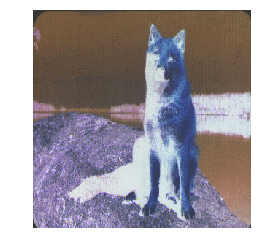

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

img = data_sets.test.x[179].reshape((img_side,img_side,num_channels)).copy()
plt.axis('off')
print(img.shape)
img /= 2
img += 0.5
img *= 255.

plt.imshow(np.array(img).reshape(img_side,img_side,3))
plt.show()

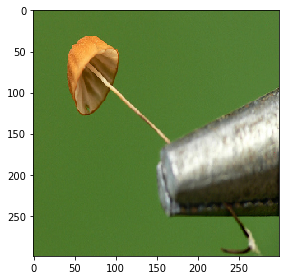

In [30]:
img = data_sets.train.x[706].reshape((img_side,img_side,num_channels)).copy()
render_img(img)

In [17]:
data_sets.test.x.shape

(150, 268203)

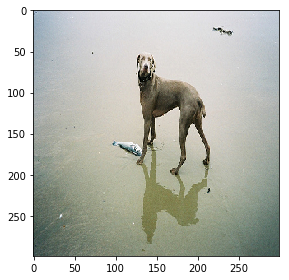

In [50]:
# render_img(attack_success)
img_attack = attack_success.reshape((img_side,img_side,num_channels))
render_img(img_attack)
print()

In [58]:
from keras.preprocessing import image

img2 = image.load_img("../../5classes/n01608432/n01608432_10016.JPEG")
img2.size

(500, 334)

In [56]:
img.size

(299, 299)

In [65]:
print(grad_influence_wrt_input_val_subset.shape)
pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
print(indices_to_poison)

(1500, 268203)
[ 698 1323  647  462  665  723  232  706  420 1143]


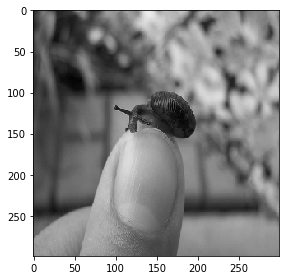

In [36]:
# for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575
# 15, 6, 23
x = data_sets.train.x[999]
# x = data_sets.train.x[1446]
# 999,  709, 1446
render_img(x.reshape((img_side,img_side,num_channels)))

In [10]:
max(data_sets.train.labels)

2.0

In [4]:
data_sets.train.x.shape

(1500, 268203)

In [7]:
np.load(orig_weight_path)

array(None, dtype=object)

In [15]:
print(num_classes)

2


In [30]:
dup = DataSet(np.copy(data_sets.test.x), np.copy(data_sets.test.labels))
dup.labels[2] = 5

In [38]:
pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
all_indices_to_poison

array([ 706,  420,  723,  236, 1323,   32, 1403,  417, 1312,  651])